Libraries and import

In [ ]:
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import TruncatedSVD
from bs4 import BeautifulSoup
import spacy
import nltk
from nltk.corpus import stopwords
import re
from wordcloud import WordCloud
import seaborn as sns

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Load Dataset in dataframe

In [ ]:
df=pd.read_excel(r'/content/drive/MyDrive/IR_project/fake job posting.xlsx')

In [ ]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI â€“ Environmental Systems Re...,"EDUCATION:Â Bachelorâ€™s or Masterâ€™s in GIS,...",Our culture is anything but corporateâ€”we hav...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17871 non-null  object
 7   requirements         15147 non-null  object
 8   benefits             10639 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

Check for duplicated rows in the dataset

In [ ]:
df[df.duplicated()]
# No duplicated Data

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent


Plot a barplot to investigate the fradulant and non fradulant job posting and their count

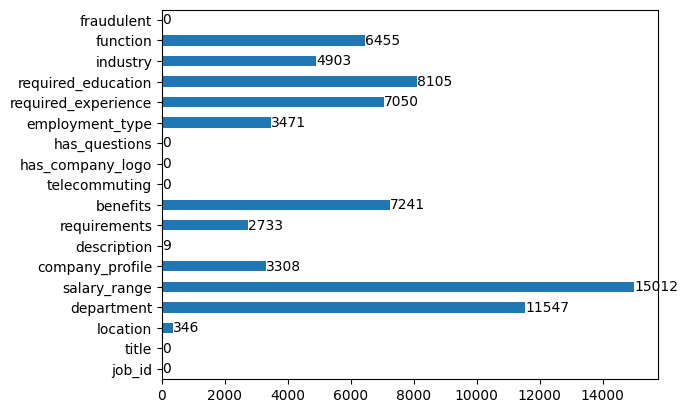

In [ ]:
import matplotlib.pyplot as plt

# Generate the horizontal bar plot
ax = df.isna().sum().plot(kind='barh')

# Iterate over the bars
for i, v in enumerate(df.isna().sum()):
    # Display the value as text on each bar
    ax.text(v, i, str(v), ha='left', va='center')

# Show the plot
plt.show()


Count of fradulant and non fradulant job postings labels 

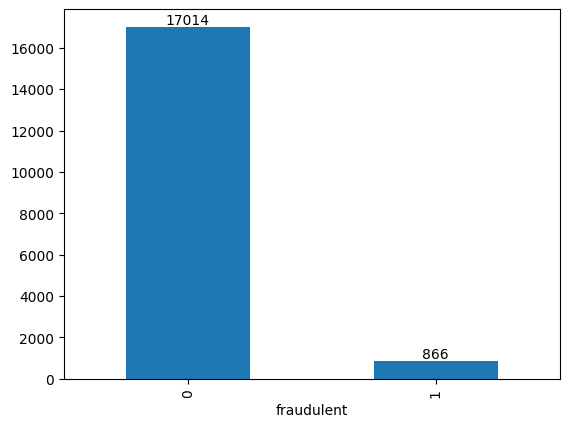

In [ ]:

# Generate the horizontal bar plot
ax = df.value_counts("fraudulent").plot(kind='bar')

# Iterate over the bars
for i, v in enumerate(df.value_counts("fraudulent")):
    # Display the value as text on each bar
    ax.text(i, v, str(v), ha='center', va='bottom')

# Show the plot
plt.show()

## Preprocessing Data

In [ ]:
del_columns=['job_id','telecommuting','has_company_logo','has_questions','salary_range']

for i in del_columns:
  del df[i]

df=df.fillna('')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17880 non-null  object
 1   location             17880 non-null  object
 2   department           17880 non-null  object
 3   company_profile      17880 non-null  object
 4   description          17880 non-null  object
 5   requirements         17880 non-null  object
 6   benefits             17880 non-null  object
 7   employment_type      17880 non-null  object
 8   required_experience  17880 non-null  object
 9   required_education   17880 non-null  object
 10  industry             17880 non-null  object
 11  function             17880 non-null  object
 12  fraudulent           17880 non-null  int64 
dtypes: int64(1), object(12)
memory usage: 1.8+ MB


Combining all text from the different features into a feature called text

In [ ]:
columns=['title','location','department','company_profile','description','requirements','benefits','employment_type','required_experience','required_education','industry','function']

for i in columns:
  df[i]=df[i].astype('str')

df['text'] = df['title']+' '+df['department']+' '+df['company_profile']+' '+df['description']+' '+df['requirements']+' '+df['benefits']+' '+df['employment_type']+' '+df['required_experience']+' '+df['required_education']+' '+df['industry']+' '+df['function']

In [ ]:
print(df['text'].head())

0    Marketing Intern Marketing We're Food52, and w...
1    Customer Service - Cloud Video Production Succ...
2    Commissioning Machinery Assistant (CMA)  Valor...
3    Account Executive - Washington DC Sales Our pa...
4    Bill Review Manager  SpotSource Solutions LLC ...
Name: text, dtype: object


Code for cleaning and lemmatization of the text feature

In [ ]:
stop_words = set(stopwords.words("english"))

#function to lemmatize the text
load_model = spacy.load('en_core_web_sm',disable = ['parser','ner'])
def lemmatize(text):
    doc = load_model(text)
    tex= " ".join([token.lemma_ for token in doc])
    return tex


#function to clean the whole text
def clean_text(text):
    #Converting to lowercase
    text = text.lower()
    #Removing emails
    text = re.sub(r'([a-zA-Z0-9+._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)', '', text)
    #Removing URLs
    text = re.sub(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '', text)
    #Removing HTML tags
    text = BeautifulSoup(text, 'lxml').get_text()
    #Removing punctuations and numbers
    text = re.sub('[^A-Z a-z ]+', ' ', text)
    #Removing Multiple spaces
    text =  " ".join(text.split())
    #Removing Stop words
    text =  " ".join([t for t in text.split() if t not in stop_words])
    #lemmatizing the text
    text = lemmatize(text)
    return text

In [ ]:
df['pre_processed'] = df['text'].apply(clean_text)

<ipython-input-15-52bd71cba2c7>:25: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'lxml').get_text()


In [ ]:
df['pre_processed'].head()

0    market intern marketing food create groundbrea...
1    customer service cloud video production succes...
2    commission machinery assistant cma valor servi...
3    account executive washington dc sale passion i...
4    bill review manager spotsource solution llc gl...
Name: pre_processed, dtype: object

Seperating the fradulant and non fradulant data for data analysis

In [ ]:
df1=df[df['fraudulent']==0]
df2=df[df['fraudulent']==1]

text_data1 = ' '.join(df1['pre_processed'].tolist())

text_data2 = ' '.join(df2['pre_processed'].tolist())

Word Cloud of non fradulant job posting

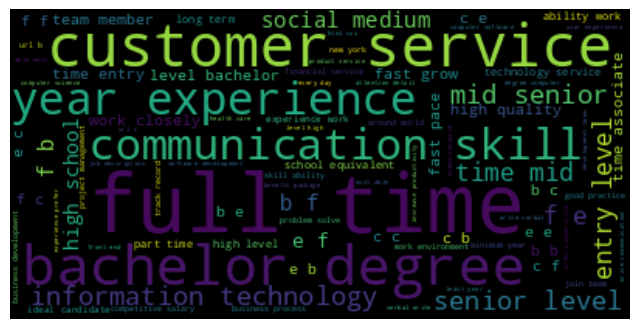

In [ ]:
# Generate word cloud
wordcloud1 = WordCloud().generate(text_data1)

# Create and configure the plot
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis('off')

# Display the plot
plt.show()


Word Cloud of Fradulant job postings

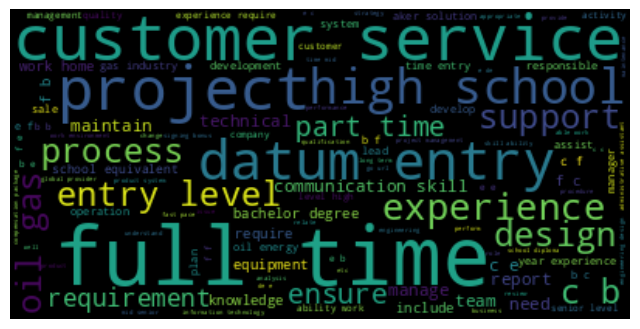

In [ ]:
# Generate word cloud
wordcloud2 = WordCloud().generate(text_data2)

# Create and configure the plot
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis('off')

# Display the plot
plt.show()


CLustering analysis to check for purity

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Purity:  0.9515659955257271


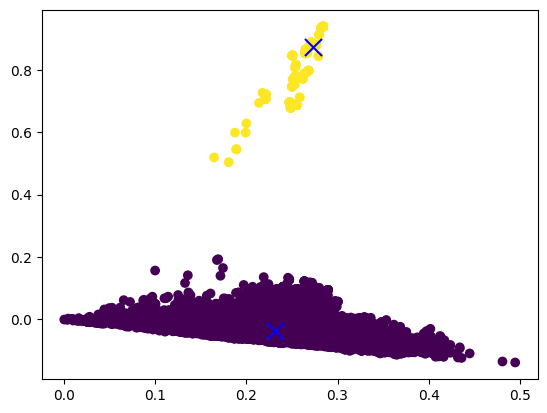

In [ ]:
# Vectorize your text data into a TF-IDF matrix
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['pre_processed'])

# KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

# Assign the generated labels to a new column in your DataFrame
df['cluster'] = kmeans.labels_

def purity_score(y_true, y_pred):
    # compute confusion matrix
    confusion_matrix_ = confusion_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(confusion_matrix_, axis=0)) / np.sum(confusion_matrix_)


purity = purity_score(df['fraudulent'], df['cluster'])
print("Purity: ", purity)

# sns.scatterplot(data=df, x='pre_processed', y='fraudulent', hue='cluster', palette='viridis')
# plt.show()

# from sklearn.decomposition import PCA

# # Use PCA to reduce dimensions to 2
# pca = PCA(n_components=2)
# reduced_features = pca.fit_transform(X.toarray())

# # reduce the cluster centers to 2D
# reduced_cluster_centers = pca.transform(kmeans.cluster_centers_)

# plt.scatter(reduced_features[:,0], reduced_features[:,1], c=kmeans.predict(X))
# plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')
# plt.show()


# Use TruncatedSVD to reduce dimensions to 2
svd = TruncatedSVD(n_components=2)
reduced_features = svd.fit_transform(X)

# reduce the cluster centers to 2D
reduced_cluster_centers = svd.transform(kmeans.cluster_centers_)

plt.scatter(reduced_features[:,0], reduced_features[:,1], c=kmeans.predict(X))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')
plt.show()
